# Introduction

> This dataset is , there is a file that contains data describtion

# Libraries 📚

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingRegressor
from xgboost.sklearn import XGBRegressor, XGBRFRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pyplot as plt


# Importing Data

In [2]:
train_path = './data/train.csv'
test_path = './data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


# Data Exploration

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

we can see some columns have null values BUT:
* if we reed the data describtion, we will realize that Alley has NA as a real value indicating *No Alley Access* so we should take care and **DON'T** drop it.
* same for FireplaceQu, NA means no Fireplace, so it's **NOT** a missing value so we need to keep it.
* same for Fence, NA means no Fence, it's **NOT** a mising value.
* same for PoolQC, NA means no pool , it's **NOT** a missing value.
* same for MiscFeature, NA means no Miscellaneous features not covered, it's **NOT** a missing value.
* same for ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] , NA means no Basement, it's **NOT** a missing value.
* same for ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], NA means no Garage, it's **NOT** a missing value.

but for ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical','GarageYrBlt'], these columns have missing values so we need to invistigate them further.

 ['OverallQual' , 'OverallCond'] these two are categorical ordinal variable but they are represented in the data as int, so we need to handle them 

for YearBuilt and YearRemodAdd, they should be the same unless a remodeling has been done
so we can have a new feature **Remodeled** with **0** for no remodeling or addintion and **1** for remodling or addition

## Univariant Exploration

In [4]:
###  numerical variables
num_var = [col for col in train_df.columns if train_df[col].dtype != 'object']
print("Numerical Features are: \n")
print(num_var)
print("")

Numerical Features are: 

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']



In [5]:
def num_uni_graphs(features):
    fig = plt.figure(figsize=(18,20))

    for i in range(len(features)):
        plt.subplot(10,4,i+1)
        plt.hist(train_df[features[i]])
        plt.title(features[i])
        plt.xlabel("Value")
        plt.ylabel("Count")
    fig.tight_layout()

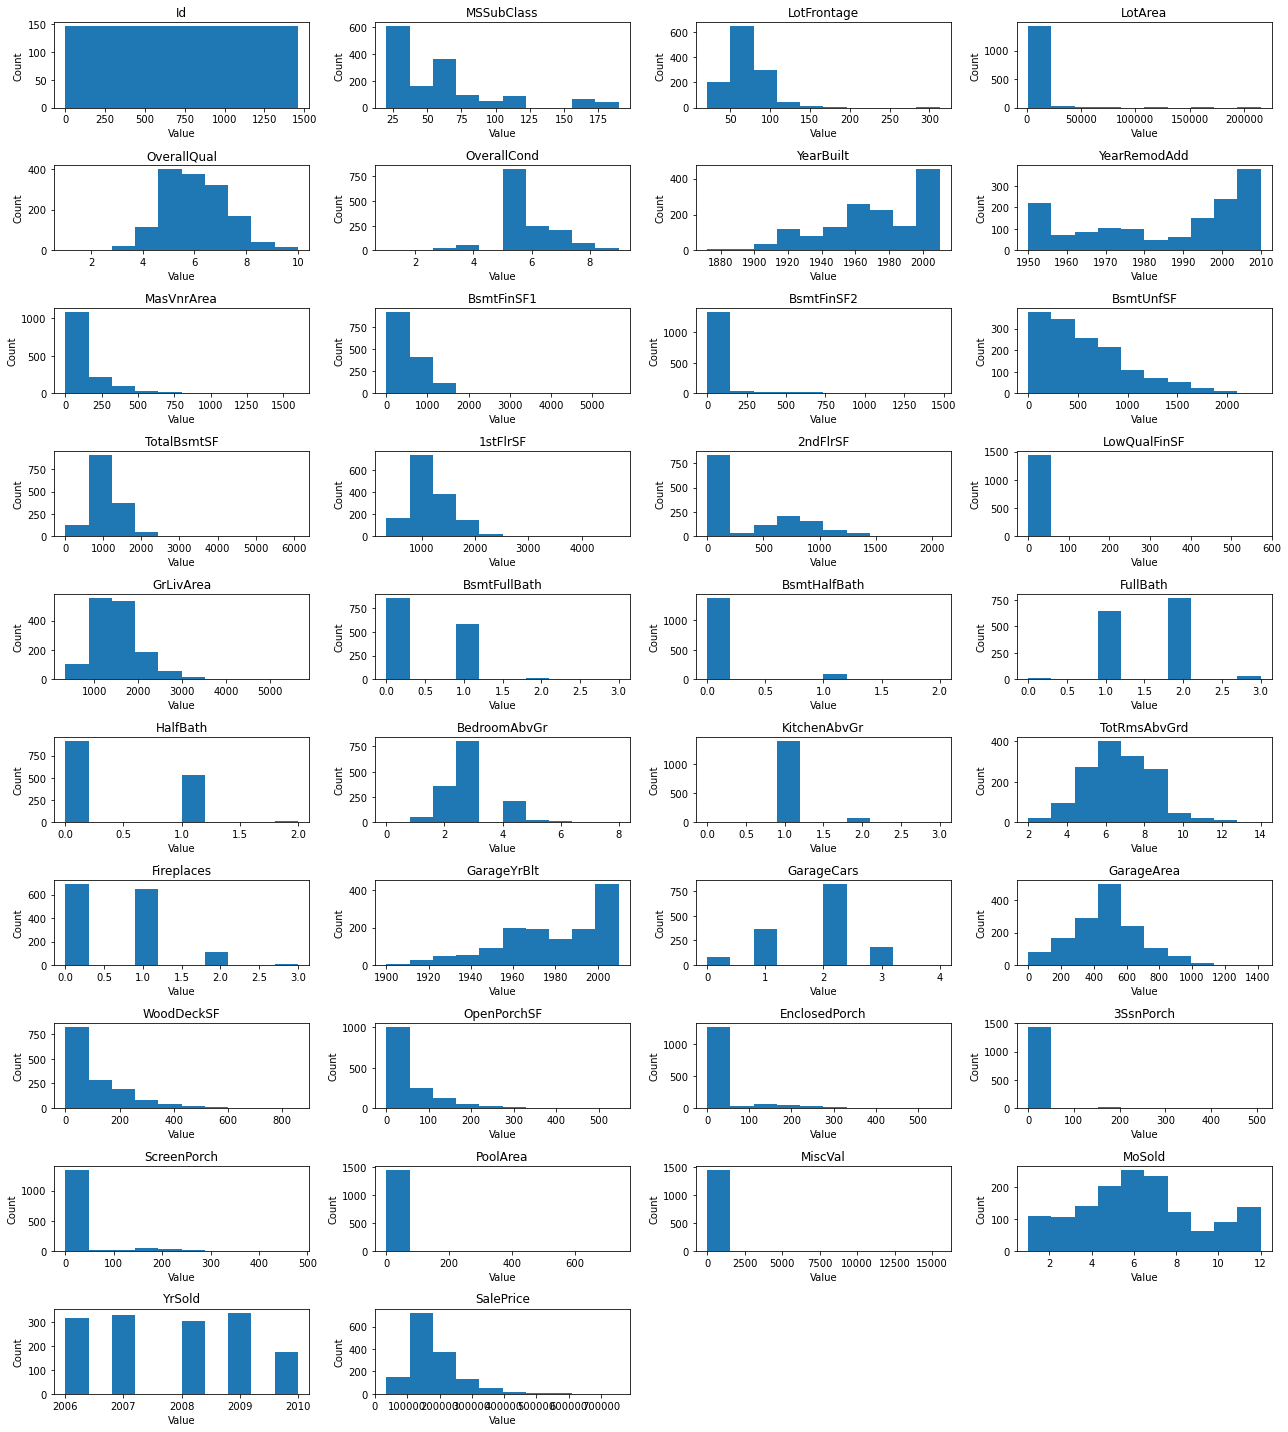

In [7]:
num_uni_graphs(num_var)

from the graphs we can see some sparse columns like PoolArea, MiscVal that would harm our model later, so it's better to drop them

same for 3SsnPorch but we need to see value_counts for it to decide


some features have skewed distribution, so we need to apply log to them, like ['WoodDeckSF', 'OpenPorchSF', 'GrLivArea', '1stFlrSF, 'LotFrontage', 'MasVnrArea', 'BsmntFinSF1', 'BsmntUnfSF', 'TotalBsmntSF']

In [8]:
def apply_log(*cols):
    '''
    This function takes tuples as input and iterate on them, each value should be a column name in the dataframe
    it applies log function to that column values excpet zeros to avoid raising errors
    
    '''
    
    for col in cols:
        train_df.loc[train_df[col]>0,col] = pd.Series(np.log(train_df.loc[train_df[col]>0,col]))

        test_df.loc[test_df[col]>0,col] = pd.Series(np.log(test_df.loc[test_df[col]>0,col]))


In [9]:
apply_log('WoodDeckSF', 'OpenPorchSF', 'GrLivArea', '1stFlrSF', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF')

In [10]:
###  Categorical Variables
cat_var = [col for col in train_df.columns if train_df[col].dtype == 'object']
print("Categorical Features are: \n")
print(cat_var)

Categorical Features are: 

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [11]:
def cat_uni_graphs(features):
    fig = plt.figure(figsize=(18,20))
    for i in range(len(cat_var)):
        if i < 44:
            y = i
        else: y = 44
        plt.subplot(9,5,y+1)
        sns.barplot(x =train_df[cat_var[i]].value_counts().index,y =train_df[cat_var[i]].value_counts()).set_title(cat_var[i])
    fig.tight_layout()

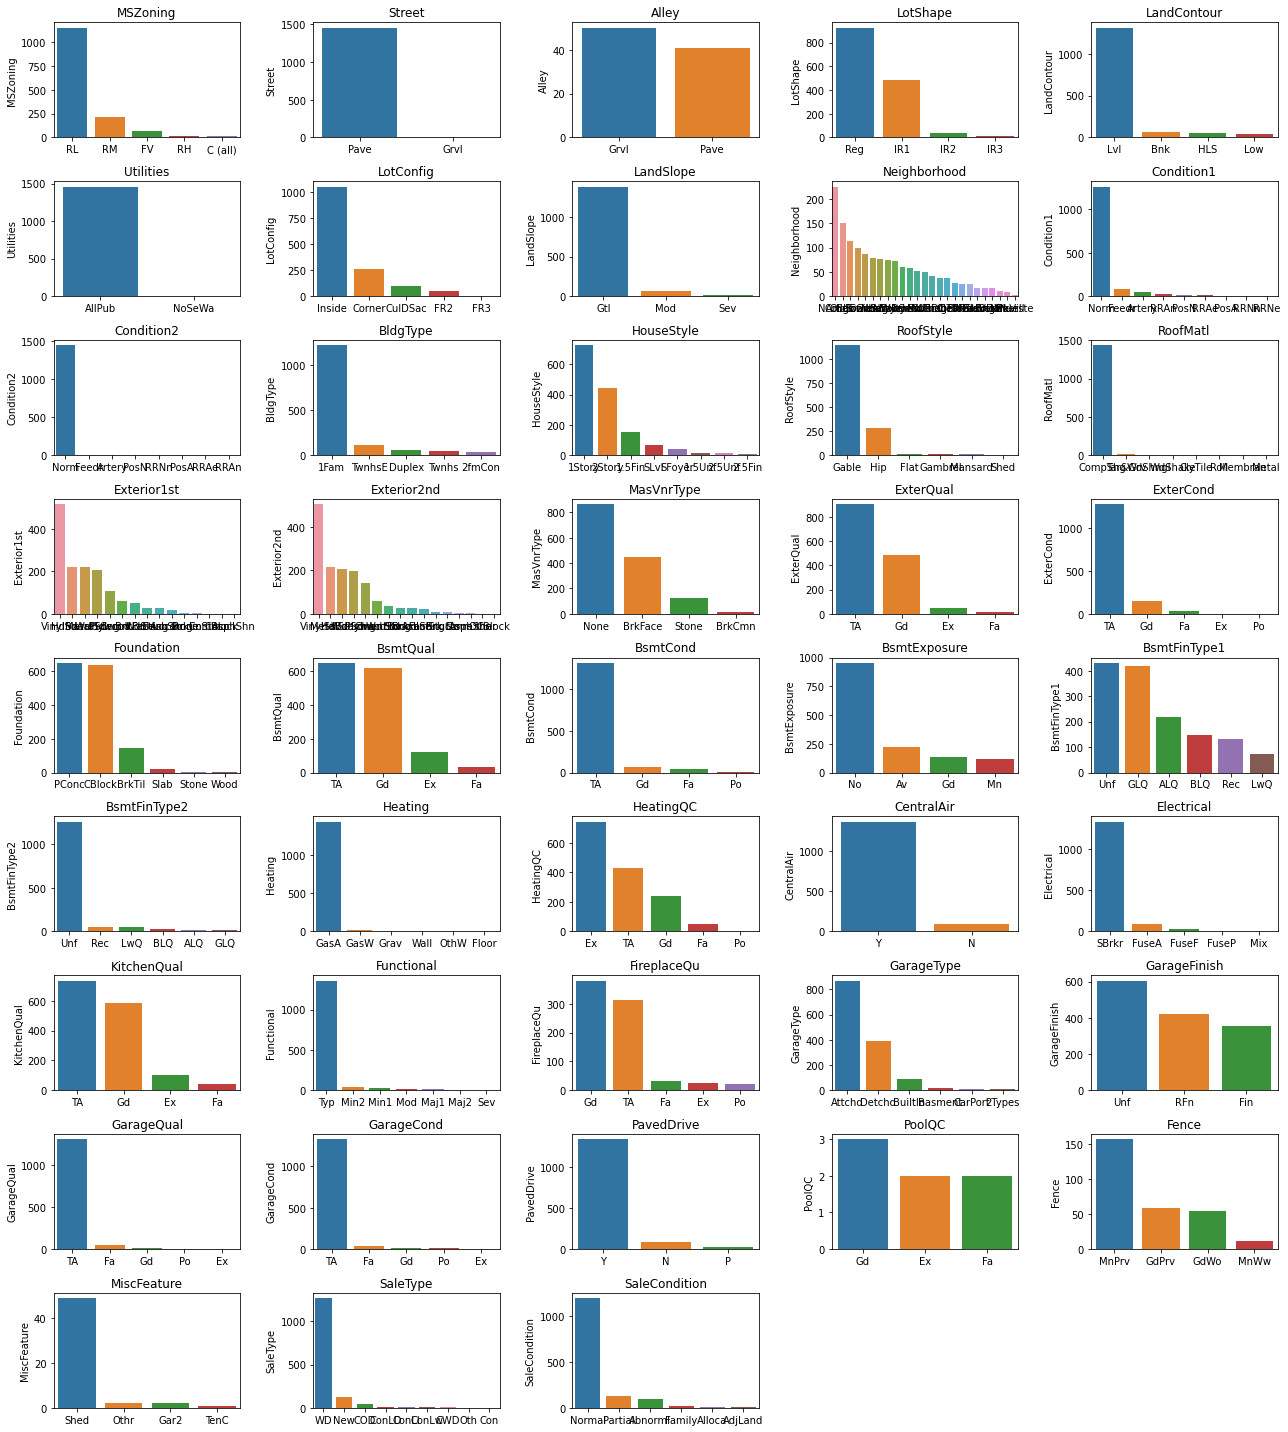

In [12]:
cat_uni_graphs(cat_var)

## Bivariant Exploration

In [36]:
###    pair-wise relations between numerical features and target 'SalePrice'
def num_Bi_graphs(features):
    fig = plt.figure(figsize=(18,20))
    for i in range(len(features)):
        if i < 44:
            y = i
        else: y = 44
        plt.subplot(10,5,y+1)
        sns.scatterplot(x =train_df[features[i]],y =train_df['SalePrice']).set_title(features[i])
    fig.tight_layout()

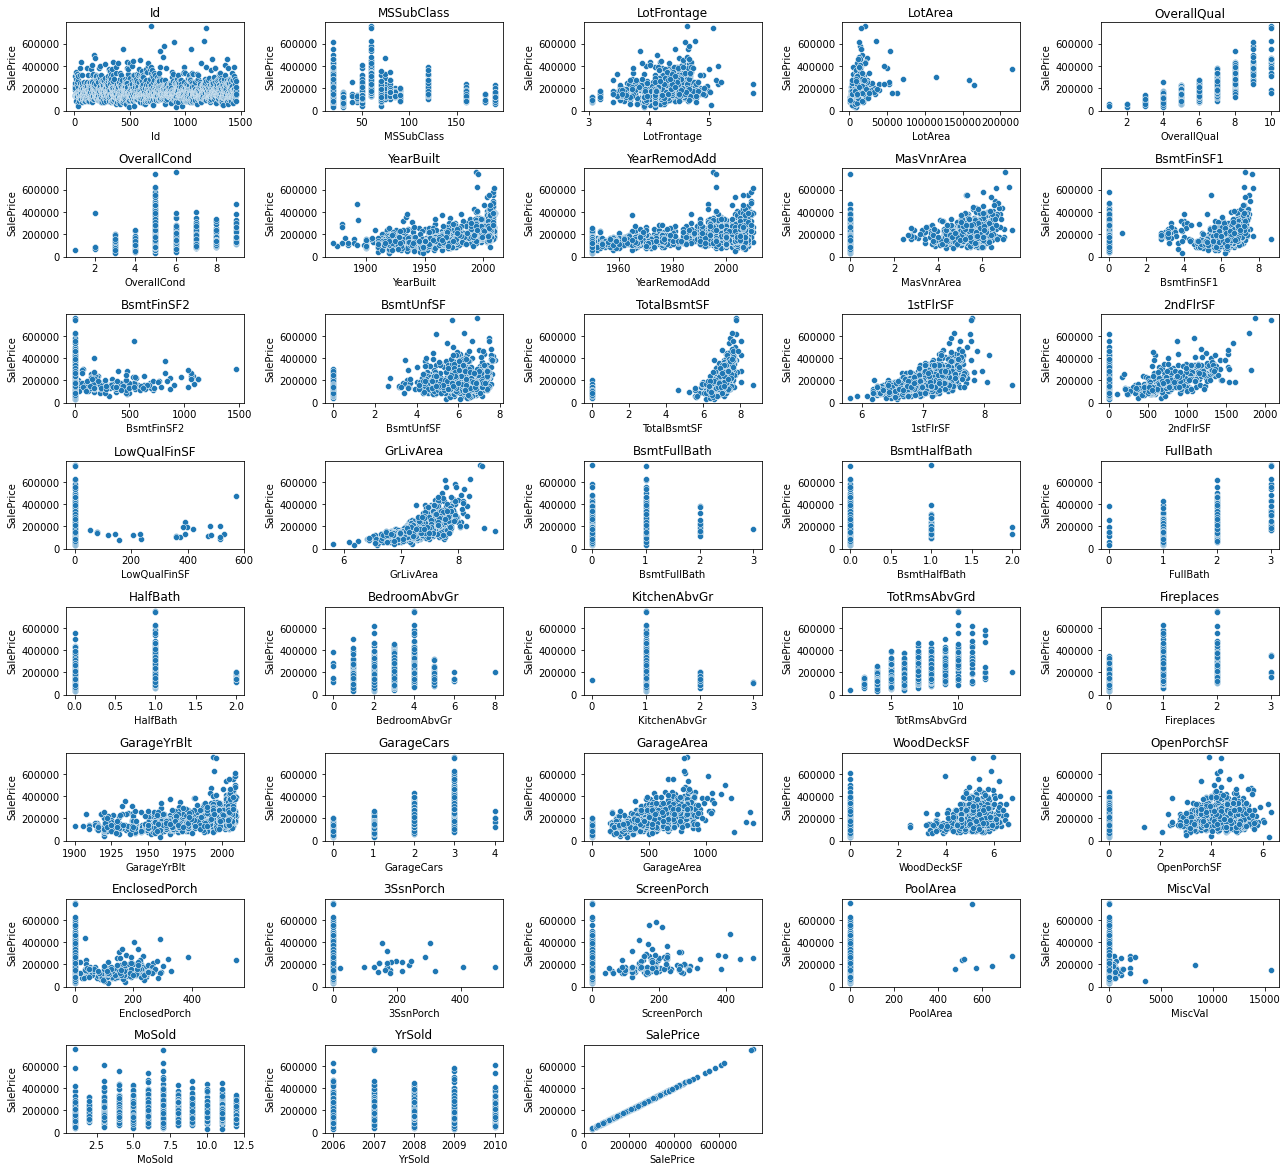

In [37]:
num_Bi_graphs(num_var)

## Exploring Missing Values
### LotFrontage

 Describtion: Linear Feet of street connected to property

In [ ]:
### Adding new Feature Remodeled

train_df['remodeled'] = 0
train_df.loc[(train_df['YearBuilt']!= train_df['YearRemodAdd']), 'remodeled'] = 1

test_df['remodeled'] = 0
test_df.loc[(test_df['YearBuilt']!= test_df['YearRemodAdd']), 'remodeled'] = 1

In [ ]:
train_df['LotFrontage'].describe()

In [ ]:
###  LotFrontage

sns.displot(data = train_df, x= 'LotFrontage')

it's numeric column, with right skewed distribution and missing values, so first we should find a way to habdle the missing values and then apply log to the values to make it normally distribution

I chose to fill missing values with median, for each Lot shape find the median of LotFrontage values and fill the missing values of Lot Frontage for this shape with the calculated median

In [ ]:
train_df['LotShape'].value_counts()

In [ ]:
mean_values = train_df.groupby('LotShape')['LotFrontage'].median()
mean_values

In [ ]:
###  Handle null values 
i = 0
for shape in mean_values.index:
    ### 1. first get rows where LotShape = shape, and fill the missing values of Lot Frontage with the previous calculated median
    train_df.loc[((train_df['LotFrontage'].isna()) & (train_df['LotShape']==shape)), 'LotFrontage']= mean_values[i]
    ### 2. we can do the same for test dataset
    test_df.loc[((test_df['LotFrontage'].isna()) & (test_df['LotShape']==shape)), 'LotFrontage']= mean_values[i]
    i+=1


In [ ]:
sns.displot(data = train_df, x= 'LotFrontage')

In [ ]:
###  apply log to LotFrontage values
train_df['LotFrontage'] = pd.Series(np.log(train_df['LotFrontage']))
test_df['LotFrontage'] = pd.Series(np.log(test_df['LotFrontage']))

sns.displot(data = train_df, x= 'LotFrontage')

In [ ]:
sns.displot(data = train_df, x= 'PoolArea')

we will drop this column and leave PoolQC, since most of the values = 0, which don't add something to our model

**Lot Area**

the distribution is right skewed, so it would be better if we apply  log to it to make it normally distributed

In [ ]:
sns.displot(data = train_df, x = 'LotArea')

In [ ]:
###  apply log to LotFrontage values
test_df['LotArea'] = pd.Series(np.log(test_df['LotArea']))

train_df['LotArea'] = pd.Series(np.log(train_df['LotArea']))
sns.displot(data = train_df, x= 'LotArea')

**BsmtFinSF1 & BsmtFinSF2**

the distribution is right skewed, so it would be better if we apply  log to it to make it normally distributed

In [ ]:
sns.displot(data = train_df, x = 'BsmtFinSF1')

In [ ]:
###  apply log to LotFrontage values
test_df.loc[test_df['BsmtFinSF1']>0,'BsmtFinSF1'] = pd.Series(np.log(test_df.loc[test_df['BsmtFinSF1']>0,'BsmtFinSF1']))


train_df.loc[train_df['BsmtFinSF1']>0,'BsmtFinSF1'] = pd.Series(np.log(train_df.loc[train_df['BsmtFinSF1']>0,'BsmtFinSF1']))
sns.displot(data = train_df, x= 'BsmtFinSF1')

In [ ]:
sns.displot(data = train_df, x = 'BsmtFinSF2')

In [ ]:
###  apply log to LotFrontage values
test_df.loc[test_df['BsmtFinSF2']>0,'BsmtFinSF2'] = pd.Series(np.log(test_df.loc[test_df['BsmtFinSF2']>0,'BsmtFinSF2']))


train_df.loc[train_df['BsmtFinSF2']>0,'BsmtFinSF2'] = pd.Series(np.log(train_df.loc[train_df['BsmtFinSF2']>0,'BsmtFinSF2']))
sns.displot(data = train_df, x= 'BsmtFinSF2')

In [ ]:
sns.displot(data = train_df, x = 'TotalBsmtSF')

In [ ]:


###  apply log to LotFrontage values
test_df.loc[test_df['TotalBsmtSF']>0,'TotalBsmtSF'] = pd.Series(np.log(test_df.loc[test_df['TotalBsmtSF']>0,'TotalBsmtSF']))


train_df.loc[train_df['TotalBsmtSF']>0,'TotalBsmtSF'] = pd.Series(np.log(train_df.loc[train_df['TotalBsmtSF']>0,'TotalBsmtSF']))
sns.displot(data = train_df, x= 'TotalBsmtSF')

In [ ]:
sns.displot(data = train_df, x = '1stFlrSF')

In [ ]:

###  apply log to LotFrontage values
test_df.loc[test_df['1stFlrSF']>0,'1stFlrSF'] = pd.Series(np.log(test_df.loc[test_df['1stFlrSF']>0,'1stFlrSF']))


train_df.loc[train_df['1stFlrSF']>0,'1stFlrSF'] = pd.Series(np.log(train_df.loc[train_df['1stFlrSF']>0,'1stFlrSF']))
sns.displot(data = train_df, x= '1stFlrSF')

In [ ]:
sns.displot(data = train_df, x = '2ndFlrSF')

In [ ]:

###  apply log to LotFrontage values
test_df.loc[test_df['2ndFlrSF']>0,'2ndFlrSF'] = pd.Series(np.log(test_df.loc[test_df['2ndFlrSF']>0,'2ndFlrSF']))


train_df.loc[train_df['2ndFlrSF']>0,'2ndFlrSF'] = pd.Series(np.log(train_df.loc[train_df['2ndFlrSF']>0,'2ndFlrSF']))
sns.displot(data = train_df, x= '2ndFlrSF')

In [ ]:
sns.displot(data = train_df, x = 'LowQualFinSF')

In [ ]:

###  apply log to LotFrontage values
test_df.loc[test_df['LowQualFinSF']>0,'LowQualFinSF'] = pd.Series(np.log(test_df.loc[test_df['LowQualFinSF']>0,'LowQualFinSF']))


train_df.loc[train_df['LowQualFinSF']>0,'LowQualFinSF'] = pd.Series(np.log(train_df.loc[train_df['LowQualFinSF']>0,'LowQualFinSF']))
sns.displot(data = train_df, x= 'LowQualFinSF')

**MasVnrType**

In [ ]:
train_df['MasVnrType'].unique()

we got two columns about Masonry veneer, **MasVnrType** & **MasVnrArea** we need to check that the null values in both of them are in the same rows, if so we can make their area = 0

In [ ]:
###  we fill missing values of MasVnrArea with zeros indicating that no MasVnr and by logical the area then should be 0
train_df.loc[train_df['MasVnrType'].isna() == True, 'MasVnrArea']= 0
###  we do the same for test datset
test_df.loc[test_df['MasVnrType'].isna() == True, 'MasVnrArea']= 0

In [ ]:
train_df['MasVnrType'].isna().sum()

In [ ]:
### we fill the missing values of MasVnrType with None
train_df.loc[train_df['MasVnrType'].isna() == True, 'MasVnrType']= 'Stone'
### we do the same for test dataset
test_df.loc[test_df['MasVnrType'].isna() == True, 'MasVnrType']= 'Stone'


In [ ]:
sns.countplot(data = train_df, x = 'MasVnrType')

In [ ]:
sns.displot(data = train_df, x= 'MasVnrArea')

In [ ]:
###  apply log to LotFrontage values, we need to be carefull with zeros as log(0) would get us error
###  so we apply log to non-zero values

train_df.loc[train_df['MasVnrArea']>0,'MasVnrArea'] = pd.Series(np.log(train_df.loc[train_df['MasVnrArea']>0,'MasVnrArea']))
test_df.loc[test_df['MasVnrArea']>0,'MasVnrArea']= pd.Series(np.log(test_df.loc[test_df['MasVnrArea']>0,'MasVnrArea']))

sns.displot(data = train_df, x= 'MasVnrArea')

**Electrical**

there is a single row with missing value for this column so we can fill it with the most frequent value **SBrkr**

In [ ]:
train_df[(train_df['Electrical'].isna()==True)]

In [ ]:
train_df.loc[train_df['Electrical'].isna()==True, 'Electrical'] = 'SBrkr'
test_df.loc[test_df['Electrical'].isna()==True, 'Electrical'] = 'SBrkr'

In [ ]:
sns.countplot(data = train_df, x = 'Electrical')

since **SBrkr** is the most frequent value, we can reconstruct this column to have values ['SBrkr', 'Not SBrkr']

In [ ]:
train_df.loc[(train_df['Electrical'] != 'SBrkr'), 'Electrical']= 'Not SBrkr'
test_df.loc[(test_df['Electrical'] != 'SBrkr'), 'Electrical']= 'Not SBrkr'

**Garage**

In [ ]:
(train_df['GarageType'].isna() & train_df['GarageYrBlt'].isna()).sum()

same as MasVnrType, the rows with NA value for GarageType, have missing values in GarageYrBlt, so we can put their year value = 0

In [ ]:
train_df.loc[(train_df['GarageType'].isna() == True, 'GarageYrBlt')]= 0
test_df.loc[(test_df['GarageType'].isna() == True, 'GarageYrBlt')]= 0

In [ ]:
train_df['GarageYrBlt'].isna().sum()

In [ ]:
(train_df['GarageType'].isna() & train_df['GarageYrBlt'].isna()).sum()

In [ ]:
sns.countplot(data = train_df, x = 'MSSubClass')

In [ ]:
sns.heatmap(train_df[['LotFrontage', 'LandContour', 'LotShape', 'LotConfig', 'LandSlope', 'SalePrice']].corr(), cmap = 'BrBG', fmt = '.2f', annot = True)

## Data Cleaning

In [ ]:
def encoding(data):
    for col in data.columns:
        if (data[col].dtype == 'object'):
            data[col] = pd.Categorical(data[col])
            data[col] = data[col].cat.codes
            if (len(data[data[col]== -1]) !=0):
                data[col] = data[col] + 1
    return data

In [ ]:
train_df = encoding(train_df)
test_df = encoding(test_df)

In [ ]:
train_df.head()

In [ ]:
train_df.isna().sum().sum()

In [ ]:
train_df = train_df.drop('Id', axis = 1)

In [ ]:
train_df['LotFrontage'].isnull().sum()

In [ ]:
y = train_df['SalePrice']

In [ ]:
train_df.drop(['SalePrice', 'PoolArea'], axis =1, inplace = True)

In [ ]:
pca = PCA(n_components = 40)
pca.fit(train_df)

x = pca.transform(train_df)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x, y, random_state = 0, test_size = 0.12)
print(len(y_train), len(y_val))

In [ ]:
vr = XGBRegressor(random_state = 0, max_depth = 20).fit(X_train, y_train)
#lr6 = GradientBoostingRegressor(random_state = 0).fit(X_train, y_train)
lr7 = XGBRFRegressor(random_forest = 0, max_depth = 20).fit(X_train, y_train)
#lr7 = HistGradientBoostingRegressor(max_depth = 5).fit(X_train, y_train)

vr = VotingRegressor(estimators = [ ('xgbrfr', lr7), ('xgbregressor', vr)]).fit(X_train, y_train)
pred = vr.predict(X_val)
#pred = lr4.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,pred)))

In [ ]:
#test_df = encoding(test_df)
test_df ['LotFrontage'] = test_df['LotFrontage'].fillna(test_df['LotFrontage'].dropna().mean())
test_df ['MasVnrArea'] = test_df['MasVnrArea'].fillna(test_df['MasVnrArea'].dropna().mean())
test_df ['BsmtFinSF1'] = test_df['BsmtFinSF1'].fillna(test_df['BsmtFinSF1'].dropna().mean())

test_df ['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(test_df['GarageYrBlt'].dropna().mean())




In [ ]:
test_df.info()

In [ ]:
test_df.loc[test_df['BsmtHalfBath'].isna(),'BsmtHalfBath']=0
test_df.loc[test_df['BsmtFullBath'].isna(),'BsmtFullBath']=0

In [ ]:
test_df.loc[test_df['GarageCars'].isna(),'GarageCars']=0

In [ ]:
Ids = test_df.Id
test_df = test_df.drop(['Id', 'PoolArea'] , axis = 1)

print(test_df.isnull().sum().sum())

print(test_df.columns[test_df.isnull().sum() !=0])

In [ ]:
test_df ['TotalBsmtSF'] = test_df['TotalBsmtSF'].fillna(test_df['TotalBsmtSF'].dropna().median())
test_df ['GarageArea'] = test_df['GarageArea'].fillna(test_df['GarageArea'].dropna().median())
test_df ['BsmtFinSF2'] = test_df['BsmtFinSF2'].fillna(test_df['BsmtFinSF2'].dropna().median())
test_df ['BsmtUnfSF'] = test_df['BsmtUnfSF'].fillna(test_df['BsmtUnfSF'].dropna().median())
test_df ['BsmtFullBath'] = test_df['BsmtFullBath'].fillna(test_df['BsmtFullBath'].dropna().median())
test_df ['BsmtHalfBath'] = test_df['BsmtHalfBath'].fillna(test_df['BsmtHalfBath'].dropna().median())
test_df ['GarageCars'] = test_df['GarageCars'].fillna(test_df['GarageCars'].dropna().median())

In [ ]:
test_df = pca.transform(test_df)
#test_df = sc.transform(test_df)

predictions = vr.predict(test_df)
data = {'Id': Ids, 'SalePrice': predictions}
output = pd.DataFrame(data)
output.to_csv('out.csv', index=False)

output.head()